In [1]:
import time
from math import log as mlog

import numpy as np
MINF = -np.inf

import emcee
import corner

from astropy.visualization import hist as ahist

In [2]:
%matplotlib inline
from matplotlib import rcParams, style
from matplotlib import pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D

rcParams['image.cmap'] = 'viridis'
rcParams['image.origin'] = 'lower'
rcParams['axes.prop_cycle'] = style.library['seaborn-deep']['axes.prop_cycle']
rcParams['figure.figsize'] = (14, 8)
rcParams['axes.titlesize'] =  rcParams['axes.labelsize'] = 16
rcParams['xtick.labelsize'] =  rcParams['ytick.labelsize'] = 14

# First build a fake GMM 

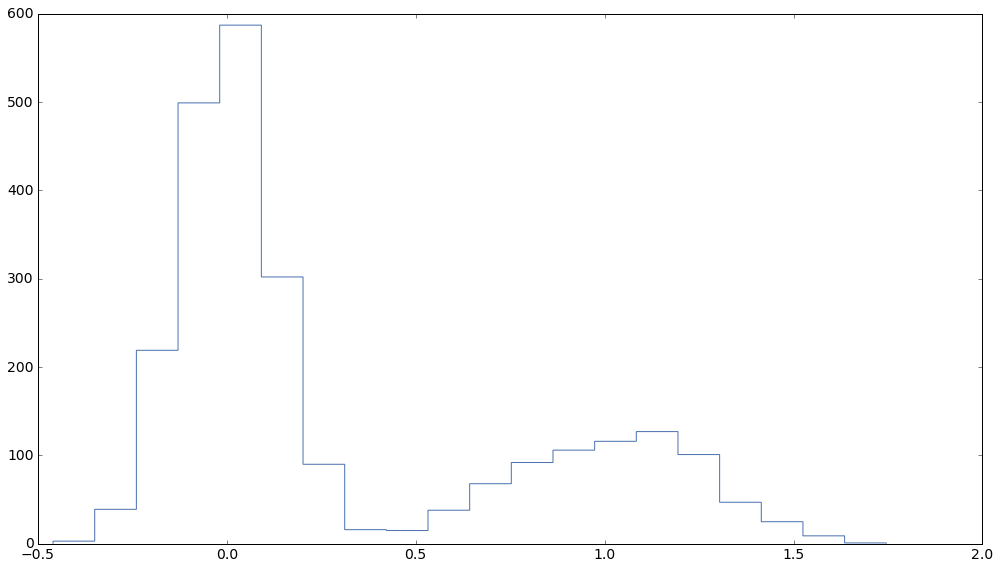

In [8]:
def make_gmm(frac1, mu1, sig1, mu2, sig2, n):
    frac2 = 1-frac1
    nboundary = round(frac1*n)

    data = np.random.randn(n)
    data[:nboundary] *= sig1
    data[:nboundary] += mu1
    data[nboundary:] *= sig2
    data[nboundary:] += mu2

    grp = np.empty(len(data))
    grp[:nboundary] = 1
    grp[nboundary:] = 2
    
    return data

true_frac1 =.7
true_mu1 = 0
true_sig1 = 0.125
true_mu2 = 1
true_sig2 = 0.25

data = make_gmm(true_frac1, true_mu1, true_sig1, true_mu2, true_sig2, 2500)

ahist(data, bins='knuth', histtype='step')
plt.tight_layout()

## Model for fitting blindly

The underlying model is:

$\mathcal{L} = P(D|M) = f_1 \mathcal{N}(\mu_1,\sigma_1) + (1-f_1) \mathcal{N}(\mu_2,\sigma_2)$

In [9]:
def lnpri(p, mubounds, sigbounds):
    f1, mu1, sig1, mu2, sig2 = p
    if f1 > 1 or f1 < 0:
        return MINF
    if not (mubounds[0] < mu1 < mubounds[1] and mubounds[0] < mu2 < mubounds[1]):
        return MINF
    if mu1 > mu2:
        return MINF
    if not (sigbounds[0] < sig1 < sigbounds[1] and sigbounds[0] < sig2 < sigbounds[1]):
        return MINF
    return 1

GAUSS_TERM = -0.5*mlog(2*np.pi)
def lnlikes_gauss(mu, sig, data):
    return -0.5 * (((data - mu) / sig) ** 2 + 2 * np.log(sig)) + GAUSS_TERM

def lnlikes(p, data):
    f1, mu1, sig1, mu2, sig2 = p
    f2 = 1 - f1
    
    lg1 = lnlikes_gauss(mu1, sig1, data)
    lg2 = lnlikes_gauss(mu2, sig2, data)
    
    return np.logaddexp(lg1 + mlog(f1), lg2 + mlog(f2))
    
def lnp(p, data, mubounds, sigbounds):
    lp = lnpri(p, mubounds, sigbounds)
    if lp == MINF:
        return MINF
    else:
        return np.sum(lp + lnlikes(p, data))

In [10]:
sampler = emcee.EnsembleSampler(10, 5, lnp, args=(data, (-1, 3), (0, 1)))

p0 = emcee.utils.sample_ball([0.75, 
                              np.mean(data), np.std(data)/2, 
                              np.mean(data), np.std(data)/2], 
                             [.001]*sampler.dim, sampler.k)

st = time.time()
res = sampler.run_mcmc(p0, 1000)[0]
sampler.reset()
res = sampler.run_mcmc(res, 1000)[0]
et = time.time()
print(et-st, 'sec')

3.021894931793213 sec


/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/emcee-2.1.0-py3.5.egg/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/emcee-2.1.0-py3.5.egg/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater


/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:600: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


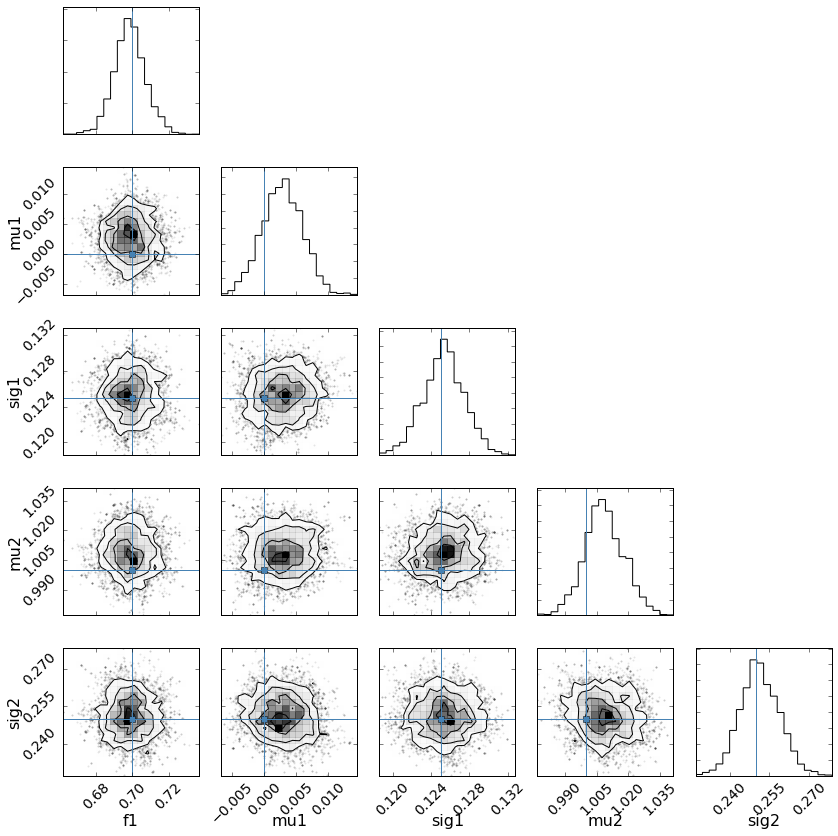

In [12]:
corner.corner(sampler.flatchain, labels='f1, mu1, sig1, mu2, sig2'.split(', '), 
              truths=[true_frac1, true_mu1, true_sig1, true_mu2, true_sig2])
plt.tight_layout()

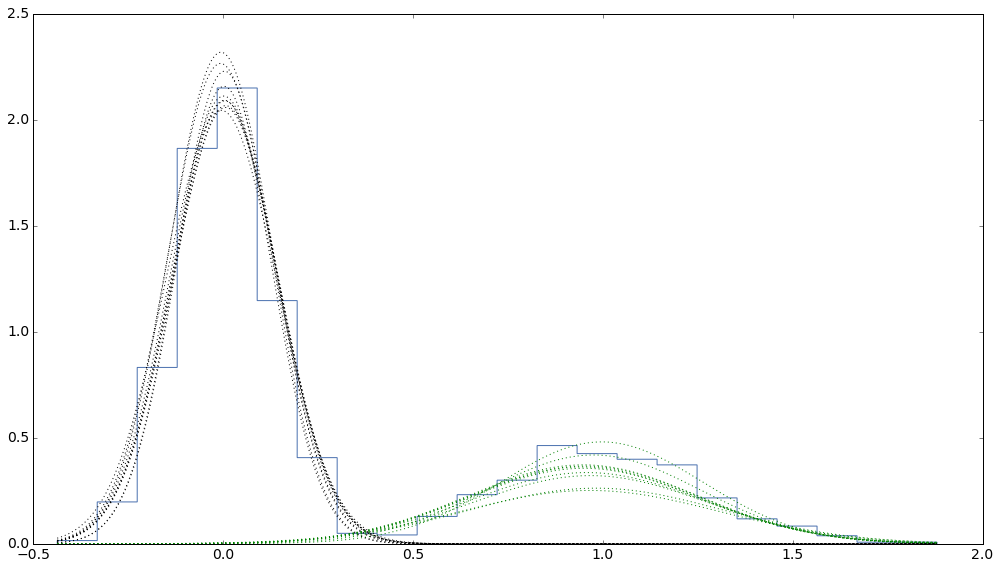

In [24]:
def show_model(data, sampler):
    ahist(data, bins='knuth', histtype='step', normed=True)

    mods = sampler.flatchain[np.random.randint(len(sampler.flatchain),size=10)]
    x = np.linspace(np.min(data), np.max(data), 1000)
    for mod in mods:
        g1 = mod[0]*np.exp(lnlikes_gauss(mod[1], mod[2], x))
        g2 = (1-mod[0])*np.exp(lnlikes_gauss(mod[3], mod[4], x))
        plt.plot(x, g1, ':k')
        plt.plot(x, g2, ':g')

    plt.tight_layout()
show_model(data, sampler)

## Try some other model sets 

In [46]:
def sample_and_show(truths, ndata=2500, nburnin=1000, nsamples=1000, mubounds=(-1, 3), sigbounds=(0, 1), walkermult=2):
    data = make_gmm(*(list(truths) + [ndata]))

    sampler = emcee.EnsembleSampler(5*walkermult, 5, lnp, args=(data, mubounds, sigbounds))

    p0 = emcee.utils.sample_ball([0.75, 
                                  np.mean(data), np.std(data)/2, 
                                  np.mean(data), np.std(data)/2], 
                                 [.001]*sampler.dim, sampler.k)

    #burnin
    st = time.time()
    res = sampler.run_mcmc(p0, nburnin)[0]
    sampler.reset()
    res = sampler.run_mcmc(res, nsamples)[0]
    et = time.time()
    print(et-st, 'sec total,', (et-st)/(nburnin + nsamples), 'sec per sample')


    fig1 = plt.figure(figsize=(6, 6))
    corner.corner(sampler.flatchain, labels='f1, mu1, sig1, mu2, sig2'.split(', '), 
                  truths=truths, figure=fig1)

    fig2 = plt.figure(figsize=(12, 5))
    show_model(data, sampler)
    
    return data, sampler, fig1, fig2

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/emcee-2.1.0-py3.5.egg/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/emcee-2.1.0-py3.5.egg/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)


6.535486936569214 sec total, 0.0016338717341423034 sec per sample


/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:600: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


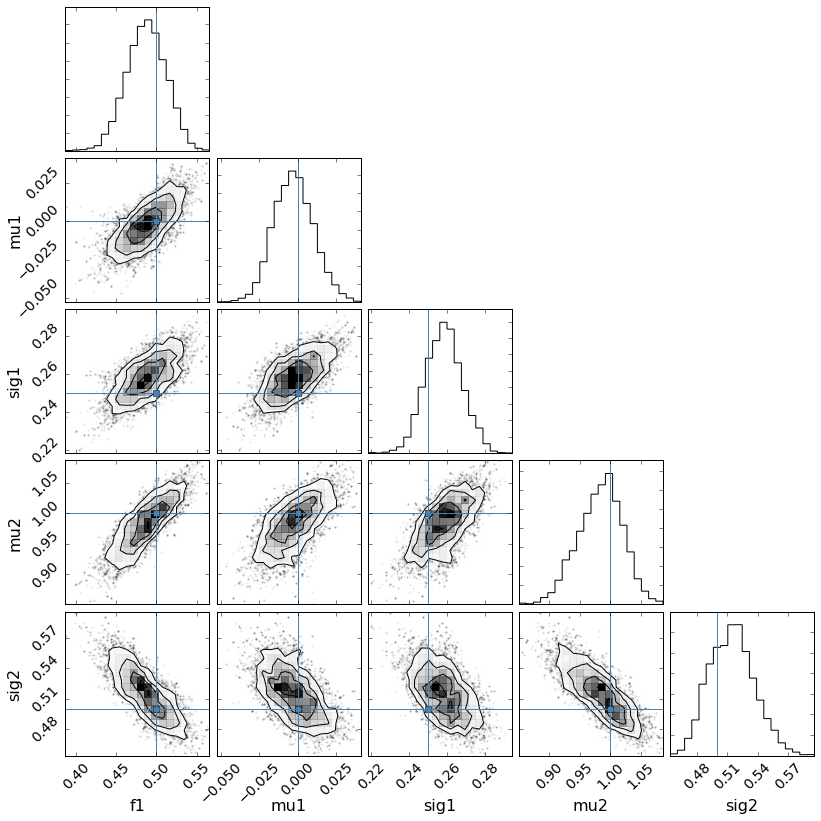

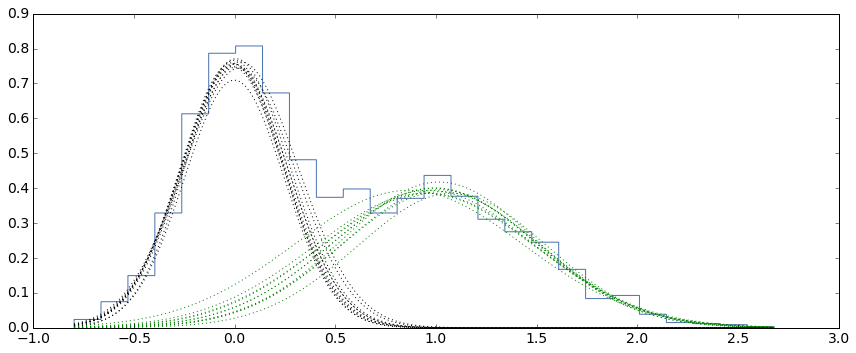

In [35]:
sample_and_show([.5, 0, 0.25, 1, 0.5], nburnin=3000)
plt.tight_layout()

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/emcee-2.1.0-py3.5.egg/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/emcee-2.1.0-py3.5.egg/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)


5.951214075088501 sec total, 0.0014878035187721253 sec per sample


/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:600: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


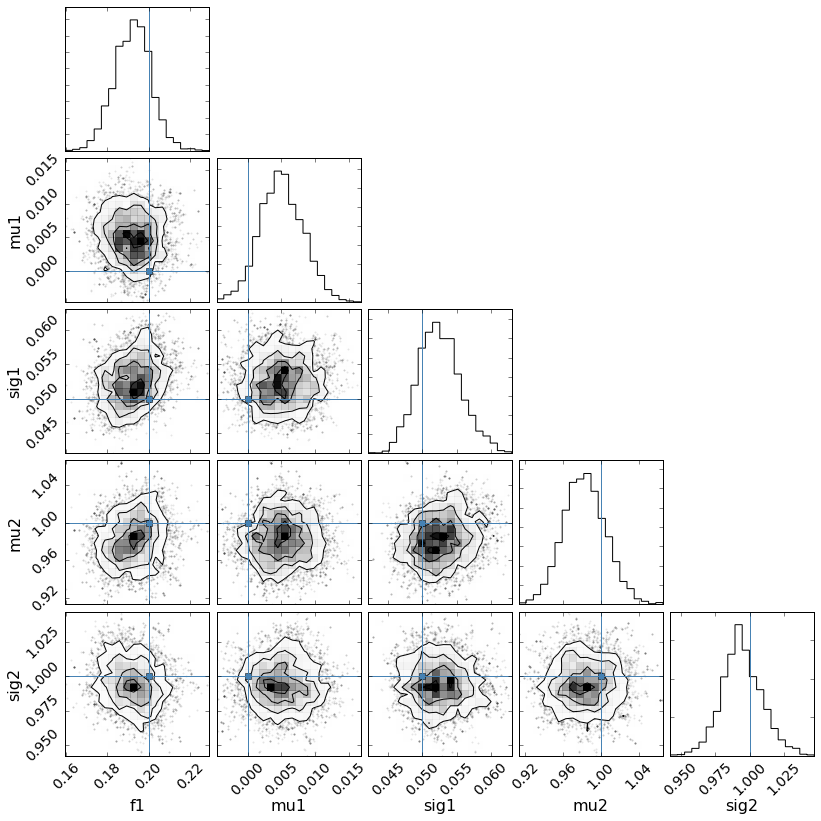

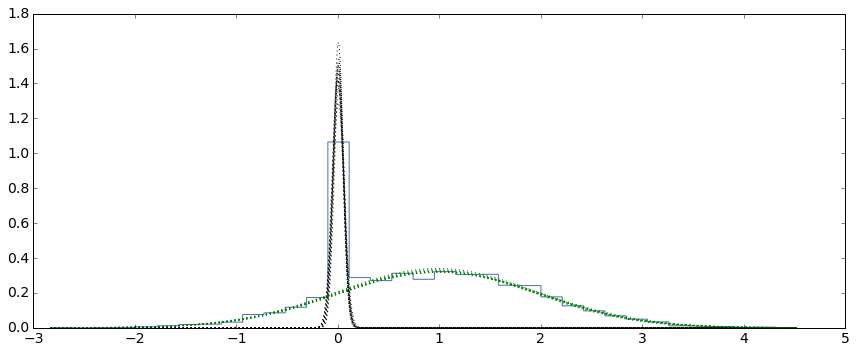

In [37]:
sample_and_show([.2, 0, 0.05, 1, 1], nburnin=3000, sigbounds=(0, 2))
plt.tight_layout()

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/emcee-2.1.0-py3.5.egg/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/emcee-2.1.0-py3.5.egg/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)


8.862205028533936 sec total, 0.0029540683428446453 sec per sample


/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:600: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


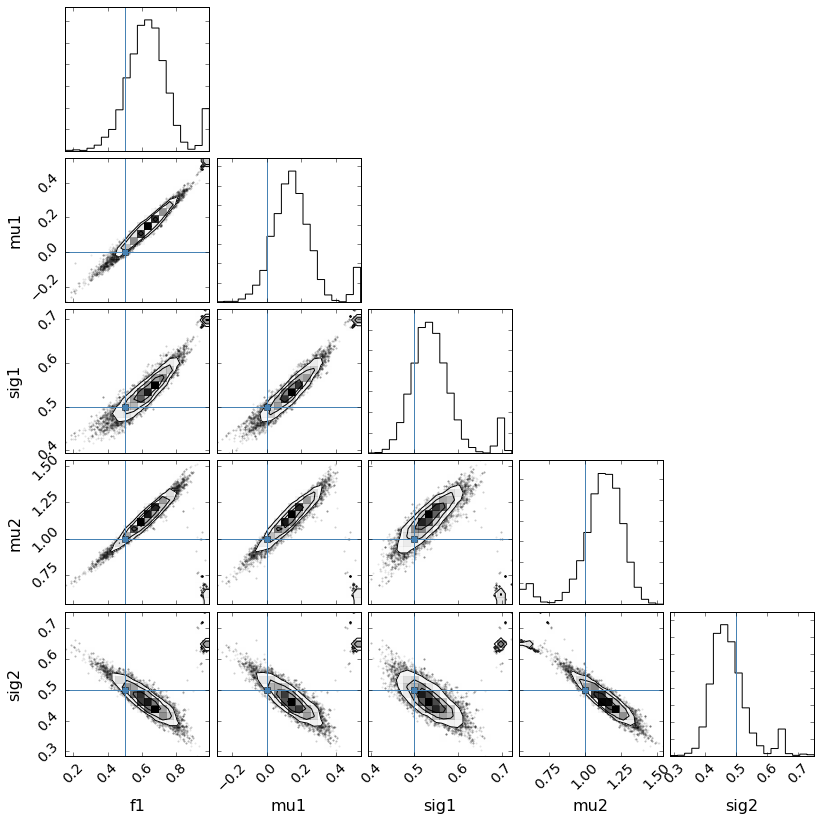

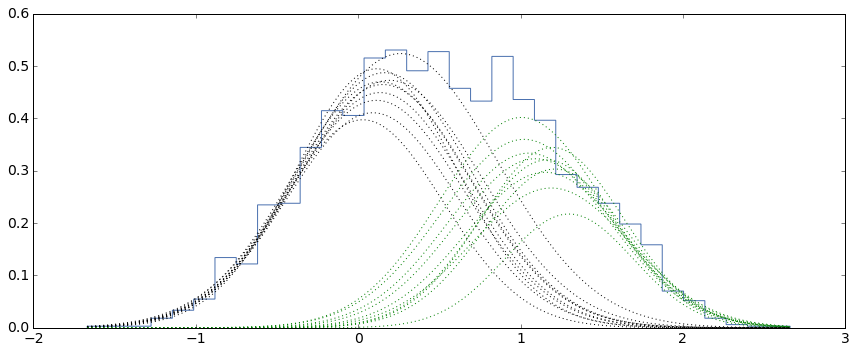

In [49]:
sample_and_show([.5, 0, 0.5, 1, 0.5], nburnin=2000, sigbounds=(0, 1), walkermult=4)
plt.tight_layout()

# Now try to assign individual point probabilities 

In [77]:
f1, mu1, sig1, mu2, sig2 = sampler.flatchain.T

ll1 = lnlikes_gauss(mu1, sig1, data.reshape(data.size, 1))
ll2 = lnlikes_gauss(mu2, sig2, data.reshape(data.size, 1))
ll1wf = ll1 + np.log(f1)
ll2wf = ll2 + np.log(1-f1)

prob1 = np.mean(np.exp(ll1wf - np.logaddexp(ll1wf, ll2wf)), axis=-1)

(-2, 3)

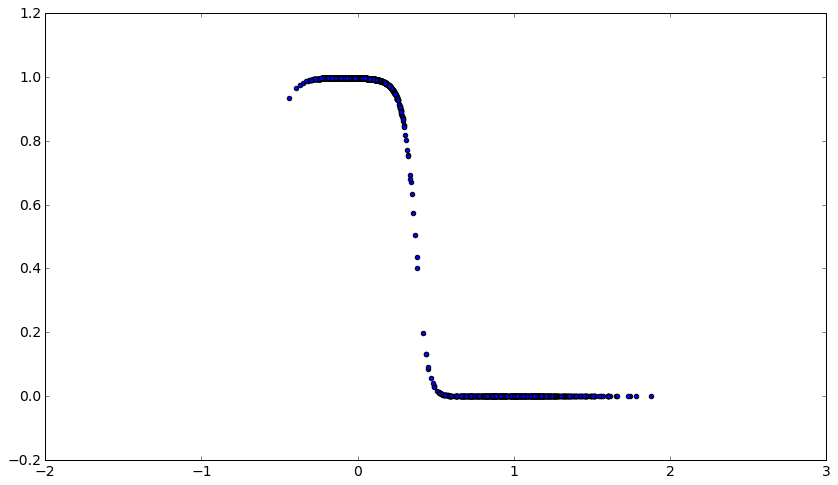

In [83]:
plt.scatter(data, prob1)
plt.xlim(-2, 3)